<h4>Import Libraries</h4>

In [15]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

<h4> Load Data, Pre-processing </h4>

In [19]:
df_grafton = pd.DataFrame(pd.read_csv("/content/sample_data/grafton-west-december-18-march-19-10.csv"))
df_parkStreet = pd.DataFrame(pd.read_csv("/content/sample_data/park-street-october-18-march-19-4.csv"))
df_queenAnnes = pd.DataFrame(pd.read_csv("/content/sample_data/queen-annes-terrace-october-18-march-19-1.csv"))

df = pd.concat([df_grafton, df_parkStreet, df_queenAnnes], ignore_index=True)
df

,Facility,Carpark,Device,Entries,Exits,Parking Duration,Time,Unnamed: 7
0,GraftonWest,Grafton West,GW Exit 2,0,1,362,01/12/2018 01:04,NaN
1,GraftonWest,Grafton West,GW Exit 1,0,1,245,01/12/2018 01:29,NaN
2,GraftonWest,Grafton West,GW Entry 1,1,0,0,01/12/2018 07:21,NaN
3,GraftonWest,Grafton West,GW Exit 1,0,1,17,01/12/2018 07:37,NaN
4,GraftonWest,Grafton West,GW Entry 2,1,0,0,01/12/2018 07:44,NaN
...,...,...,...,...,...,...,...,...
628022,Queen Anne,Queen Anne Terrace,QAT Exit 1,0,1,138,31/12/2018 22:43,NaN
628023,Queen Anne,Queen Anne Terrace,QAT Exit 1,0,1,219,31/12/2018 22:50,NaN
628024,Queen Anne,Queen Anne Terrace,QAT Entry 2,1,0,0,31/12/2018 22:50,NaN
628025,Queen Anne,Queen Anne Terrace,QAT Exit 1,0,1,168,31/12/2018 23:16,NaN


In [20]:
df['Parking Duration'] = df['Parking Duration'].str.replace(",", "").astype(int)

# 1. If exits is 0 then parking duration should be 0
condition = (df['Exits'] == 0) & (df['Parking Duration'] > 0)
df_error = df[condition]
df.loc[condition, 'Parking Duration'] = 0 #35,181 row affected

# 2. Entries XOR Exits == 1
condition = (df['Exits'] == df['Entries'])
rows_to_keep = ~condition
df = df[rows_to_keep]

<h4>Menghitung Device Yang Sering Error</h4>

In [21]:
error_percentage = (df_error.groupby('Device').size()/df.groupby('Device').size()) * 100

print("Percentage of error: ")
print(error_percentage)

Percentage of error: 
Device
GW Entry 1       0.720207
GW Entry 2       0.616016
GW Exit 1             NaN
GW Exit 2             NaN
Park St EN1A     5.577312
Park St EN1B     6.038172
Park St EX1           NaN
Park St EX2           NaN
QAT Entry 1     24.969776
QAT Entry 2     25.203231
QAT Exit 1            NaN
QAT Exit 2            NaN
dtype: float64


<h4>Perhitungan Interval Rata-rata dan Standar deviasi</h4>

In [22]:
#Initialize first
from scipy.stats import norm, chi2
import math
condition_s = df['Exits'] == 1
df_stats = df[condition_s]
jumlah_sample = len(df_stats)

In [23]:
mean = df_stats['Parking Duration'].mean()
#stdev populasi ~ stdev sample
stdev = df_stats['Parking Duration'].std()

alpha = 0.0001

z_score = norm.ppf(1-(alpha/2), 0.1)
batas_atas = mean + z_score * stdev/math.sqrt(jumlah_sample)
batas_bawah = mean - z_score * stdev/math.sqrt(jumlah_sample)

print(f"Tingkat kepercayaan: {(1-alpha)*100}%")
print(f"Rata-rata durasi parkir berada di rentang: {batas_bawah} - {batas_atas} menit")

Tingkat kepercayaan: 99.99%
Rata-rata durasi parkir berada di rentang: 153.12619996308183 - 156.35924035731455 menit


In [24]:
alpha = 0.0001

chi_atas = chi2.ppf(alpha/2, jumlah_sample-1)
chi_bawah = chi2.ppf(1-(alpha/2), jumlah_sample-1)

batas_bawah_std = stdev*np.sqrt(((jumlah_sample-1)/chi_bawah))
batas_atas_std = stdev*np.sqrt(((jumlah_sample-1)/chi_atas))

print(f"Tingkat kepercayaan: {(1-alpha)*100}%")
print(f"Standar deviasi durasi parkir berada di rentang: {batas_bawah_std} - {batas_atas_std}")

Tingkat kepercayaan: 99.99%
Standar deviasi durasi parkir berada di rentang: 225.01732670990754 - 227.2461851642309


<h4>Visualisasi dan jawaban 2a</h4>

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


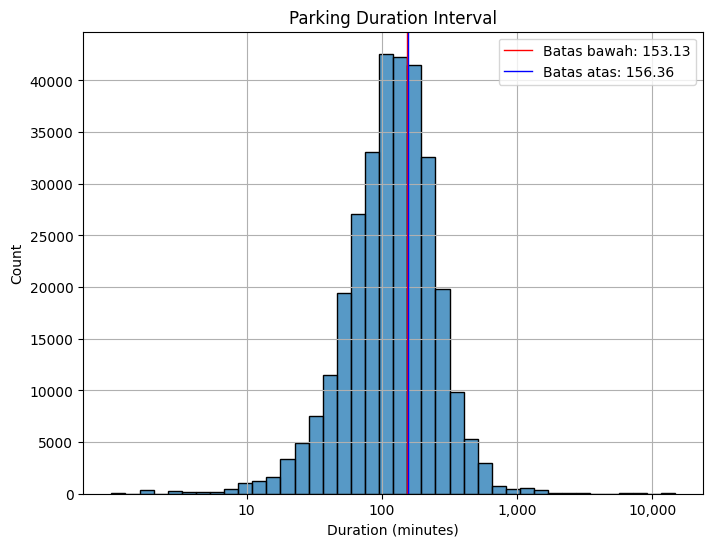

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.histplot(data=np.log10(df['Parking Duration']), bins=40)

ticks = [10, 100, 1000, 10000]

plt.xticks(np.log10(ticks), [f'{tick:,.0f}' for tick in ticks])

plt.title('Parking Duration Interval')
plt.axvline(np.log10(batas_bawah), color='red', linestyle='-', linewidth=1, label=f'Batas bawah: {batas_bawah:,.2f}')
plt.axvline(np.log10(batas_atas), color='blue', linestyle='-', linewidth=1, label=f'Batas atas: {batas_atas:,.2f}')

plt.legend()

plt.ylabel('Count')
plt.xlabel('Duration (minutes)')

plt.grid(True)
plt.show()

<h4>Jawaban 2b</h4>

In [26]:
treshold = 480

problematic = (df['Parking Duration'] > treshold)
problematic_df = df[problematic]
problematic_df_len = len(problematic_df)

df_len = len(df)

problematic_df_percentage = (problematic_df_len / df_len) * 100

print(f"Persentase penduduk Cambridge problematik (bds. sampel): {problematic_df_percentage:.2f} %")

Persentase penduduk Cambridge problematik (bds. sampel): 1.03 %


In [29]:
p = problematic_df_len / df_len
se = np.sqrt((p * (1 - p)) / df_len)
alpha = 0.05

critical_value = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1) #z-score
error_margin = critical_value * se

xl = p - error_margin
xu = p + error_margin

print("Estimasi persentase pengguna lapangan parkir bermasalah dengan tingkat kepercayaan 95%")
print(f"Batas bawah: {xl * 100:.2f}%")
print(f"Batas atas: {xu * 100:.2f}%")

Estimasi persentase pengguna lapangan parkir bermasalah dengan tingkat kepercayaan 95%
Batas bawah: 1.01%
Batas atas: 1.06%


<h4>Jawaban 2c</h4>

In [30]:
import math

def calculate_parking_cost(duration):
    hour = math.ceil(duration / 60)
    if hour < 8:
        return 0.75 * hour
    else:
        return 6.0

df['Parking Cost'] = df['Parking Duration'].apply(calculate_parking_cost)

df_non_zero = df[df['Parking Cost'] > 0]

average_income = df_non_zero['Parking Cost'].mean()
std_dev_income = df_non_zero['Parking Cost'].std()

print("Average Parking Income: £{:.2f}".format(average_income))
print("Standard Deviation of Parking Income:", (std_dev_income))

Average Parking Income: £2.18
Standard Deviation of Parking Income: 1.23031980838106


<h4>Jawaban 2d</h4>

Untuk memminimalisir pengguna bermasalah, maka kami menerapkan pengalian tarik perjam dengan faktor pengali 1.5.

In [ ]:
cost = [1,2,2,1,1,1,1,1]
sum_cost = sum(cost)

i = 8
while i <= 24:
    sum_cost = sum_cost * 1.5
    print(f"Total fee at {i} hours: {sum_cost}")
    i += 1

Total fee at 8 hours: 15.0
Total fee at 9 hours: 22.5
Total fee at 10 hours: 33.75
Total fee at 11 hours: 50.625
Total fee at 12 hours: 75.9375
Total fee at 13 hours: 113.90625
Total fee at 14 hours: 170.859375
Total fee at 15 hours: 256.2890625
Total fee at 16 hours: 384.43359375
Total fee at 17 hours: 576.650390625
Total fee at 18 hours: 864.9755859375
Total fee at 19 hours: 1297.46337890625
Total fee at 20 hours: 1946.195068359375
Total fee at 21 hours: 2919.2926025390625
Total fee at 22 hours: 4378.938903808594
Total fee at 23 hours: 6568.408355712891
Total fee at 24 hours: 9852.612533569336


Untuk meningkatkan pengguna berdurasi singkat, kami menetapkan agar 30 menit pertama menjadi gratis. 30 menit diambil karena tidak terdapat banyak pengguna pada saat itu, maka potential revenue lost tidak sebesar 60 menit pertama

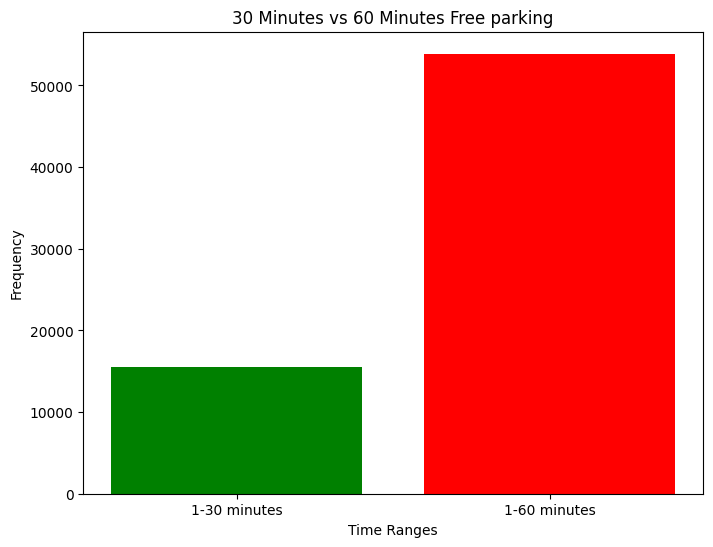

In [ ]:
ranges = ['1-30 minutes', '1-60 minutes']
time_intervals = [(1, 30), (1, 60)]
frequencies = []
for start, end in time_intervals:
    frequency = ((df["Parking Duration"] >= start) & (df["Parking Duration"] <= end)).sum()
    frequencies.append(frequency)


plt.figure(figsize=(8, 6))

plt.bar(ranges, frequencies, color=['green', 'red'])
plt.title('30 Minutes vs 60 Minutes Free parking')
plt.xlabel('Time Ranges')
plt.ylabel('Frequency')

plt.show()


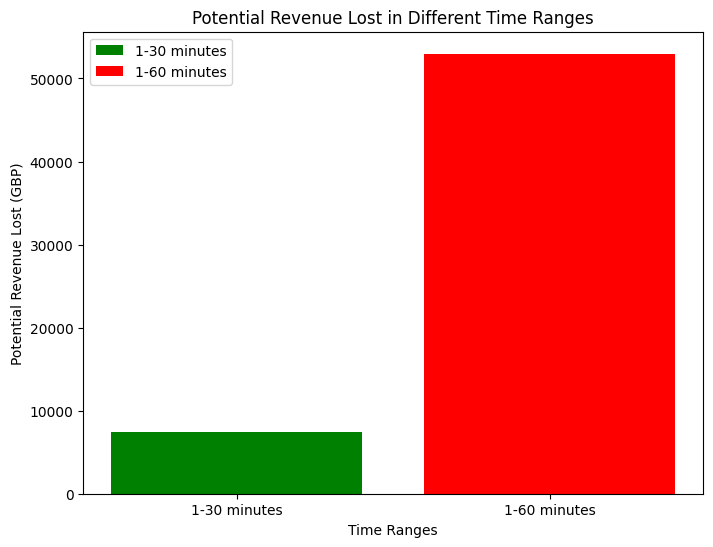

In [ ]:
ranges = ['1-30 minutes', '1-60 minutes']
time_intervals = [(1, 30), (1, 60)]


hourly_rate = 1
revenue_lost = []
revenue_gained = []

for start, end in time_intervals:
    within_range = (df["Parking Duration"] >= start) & (df["Parking Duration"] <= end)
    frequency = within_range.sum()
    if start == 1:
        revenue_lost.append(frequency * hourly_rate * (end - start) / 60)
    else:
        duration_hours = math.ceil(end / 60) - math.ceil(start / 60)
        duration_hours -= 1
        revenue_lost.append(frequency * hourly_rate * duration_hours)
        revenue_gained.append(((df["Parking Duration"] > end) & (df["Parking Duration"] <= end + 30)).sum() * hourly_rate)


if len(revenue_gained) < len(revenue_lost):
    revenue_gained.append(0)

plt.figure(figsize=(8, 6))
plt.bar(ranges[0], revenue_lost[0], color='green', label='1-30 minutes')
plt.bar(ranges[1], revenue_lost[1], color='red', label='1-60 minutes')
plt.title('Potential Revenue Lost in Different Time Ranges')
plt.xlabel('Time Ranges')
plt.ylabel('Potential Revenue Lost (GBP)')
plt.legend()

plt.show()
